In [1]:
import h5py
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.style.use('~/Python_Tool/ryan_mplstyle.mplstyle')

import numpy as np

import cmocean.cm as cmo
import dedalus.public as d3
from scipy.stats import skew

import sys
sys.path.insert(0, '../../subroutines')
from isospectrum import isospectrum

In [2]:
Ro = 0.032
randseed = 2

bt_all = np.empty([0,512,512])
bb_all = np.empty([0,512,512])
bmt_all = np.empty([0,512,512])
bmm_all = np.empty([0,512,512])

zetat_all = np.empty([0,512,512])
zetab_all = np.empty([0,512,512])
zetamt_all = np.empty([0,512,512])
zetamm_all = np.empty([0,512,512])

straint_all = np.empty([0,512,512])
div_all = np.empty([0,512,512])

for di in range(16,21):
    print(di)
    
    spname = 'EadyQGPl_sp_%.3f_%d/EadyQGPl_sp_%.3f_%d_s%i' %(Ro, randseed, Ro, randseed, di )
    spname = spname.replace(".", "d" ); spname = "../"+spname+'.h5'

    # Plot writes
    with h5py.File(spname, mode='r') as file:
        zetat_data = np.squeeze(np.array(file['tasks']['zeta_top']))*Ro
        zetab_data = np.squeeze(np.array(file['tasks']['zeta_bot']))*Ro
        
        divt_data = np.squeeze(np.array(file['tasks']['div_top']))*Ro
        straint_data = np.squeeze(np.array(file['tasks']['strain_top']))*Ro
        
        ####
        zetat_all = np.append(zetat_all,zetat_data,axis=0)
        zetab_all = np.append(zetab_all,zetab_data,axis=0)
        
        div_all = np.append(div_all,divt_data,axis=0)
        straint_all = np.append(straint_all,straint_data,axis=0)

16
17
18
19
20


In [3]:
zmax = np.max(zetat_all[:,:,:].ravel())+1e-10
zmin = np.min(zetat_all[:,:,:].ravel())

z_range = np.linspace(zmin,zmax,50)
s_range = np.arange(0,zmax,z_range[-1]-z_range[-2])

print(z_range.shape)

(50,)


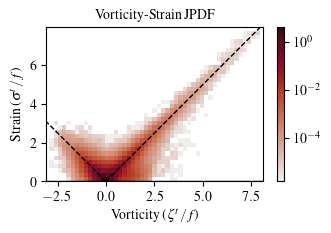

In [4]:
fig=plt.figure(figsize=(3.5, 2.0))

plt.hist2d(zetat_all[:,:,:].ravel(),straint_all[:,:,:].ravel(), density=True, bins=[z_range, s_range], cmap=cmo.amp, norm=colors.LogNorm())
axs_max = max(abs(zetat_all[:,:,:].ravel()))
plt.plot([0,axs_max],[0,axs_max],'--',color='k'); plt.plot([0,-axs_max],[0,axs_max],'--',color='k'); plt.axhline(0,color='k')
plt.axis('equal'); 
plt.xlim(min(zetat_all[:,:,:].ravel()),max(zetat_all[:,:,:].ravel()))
plt.colorbar()
plt.title('Vorticity-Strain JPDF')
plt.xlabel("Vorticity ($\zeta^t/f$)")
plt.ylabel("Strain ($\sigma^t/f$)")

figname = 'figs/EadyQGpl_jointPDFs_Ro%.2f' %(Ro)
figname = figname.replace(".", "d" ); figname = figname+'.pdf'
plt.savefig(figname, bbox_inches='tight')

plt.show()

In [5]:
za = zetat_all[:,:,:].ravel()
sa = straint_all[:,:,:].ravel()
da = div_all[:,:,:].ravel()

div_mean = np.empty((z_range.size-1,s_range.size-1))

for z_i in range(z_range.size-1):
    for s_i in range(s_range.size-1):
        z_here = (za>=z_range[z_i])*(za<z_range[z_i+1])
        s_here = (sa>=s_range[s_i])*(sa<s_range[s_i+1])
        
        div_mean[z_i,s_i] = np.mean(da[z_here*s_here])

/ext3/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/ext3/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


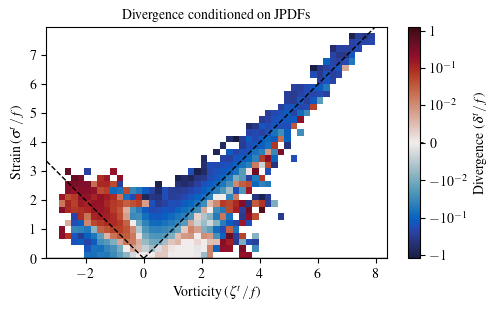

In [6]:
fig=plt.figure(figsize=(5.5, 3))

# plt.pcolor((z_range[1:]+z_range[:-1])/2,(s_range[1:]+s_range[:-1])/2,div_mean.T, cmap=cmo.balance, norm=colors.CenteredNorm())
cax = plt.pcolormesh((z_range[1:]+z_range[:-1])/2,(s_range[1:]+s_range[:-1])/2,\
           div_mean.T, cmap=cmo.balance, norm=colors.SymLogNorm(linthresh=1e-3, linscale=1e-2,vmin=(np.nanmin(div_mean)),vmax=-(np.nanmin(div_mean))))

plt.plot([0,axs_max],[0,axs_max],'--',color='k'); plt.plot([0,-axs_max],[0,axs_max],'--',color='k'); plt.axhline(0,color='k')
plt.axis('equal'); plt.xlim(min(zetat_all[:,:,:].ravel()),max(zetat_all[:,:,:].ravel()))

cbar = fig.colorbar(cax, ticks=[-1e-2,-1e-1,-1e-0, 1e-0, 1e-1, 1e-2, 0])
cbar.ax.set_yticklabels([r'$-10^{-2}$',r'$-10^{-1}$', '$-1$', '$1$', r'$10^{-1}$', r'$10^{-2}$', '$0$'])  # vertically oriented colorbar

plt.title('Divergence conditioned on JPDFs')
plt.xlabel("Vorticity ($\zeta^t/f$)")
plt.ylabel("Strain ($\sigma^t/f$)")
cbar.set_label('Divergence ($\delta^t/f$)')

figname = 'figs/EadyQGpl_condJPDF_Ro%.2f' %(Ro)
figname = figname.replace(".", "d" ); figname = figname+'.pdf'
plt.savefig(figname, bbox_inches='tight')

plt.show()

### 